# Amazon Fine Food Reviews KNN_BOW
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

Id ProductId - unique identifier for the product UserId - unqiue identifier for the user ProfileName HelpfulnessNumerator - number of users who found the review helpful HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not Score - rating between 1 and 5 Time - timestamp for the review Summary - brief summary of the review Text - text of the review Objective: Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# Loading the data
The dataset is available in two forms

1.csv file

2.SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently. Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

con = sqlite3.connect('database.sqlite')#Using SQLite table to read the data

#Filtering the data such that reviews will be only positive and negative and not considering review with score=3

data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = data['Score']
positiveNegative = actualScore.map(partition) 
data['Score'] = positiveNegative
print(data.shape)
data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [2]:
data.shape

(525814, 10)

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(data['Id'].size*1.0)*100

69.25890143662969

It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
final.shape

(364171, 10)

In [8]:
final['Score'].size

364171

In [9]:
def polarity(X):
    if X=='positive':
        return 1
    else:
        return 0
final["Score"]=final["Score"].map(polarity)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


# Text Preprocessing: Stemming, stop-word removal and Lemmatization.


Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1.Begin by removing the html tags

2.Remove any punctuations or limited set of special characters like , or . or # etc.

3.Check if the word is made up of english letters and is not alpha-numeric

4.Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5.Convert the word to lowercase

6.Remove Stopwords

7.Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

In [10]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)

{'while', 'my', 'he', 'above', 'doesn', 'just', 'why', 'hadn', 'hasn', 'ma', "weren't", 'when', 'won', "shan't", 'your', 'a', 'about', 't', 'y', 'itself', 'didn', "you're", 'but', 'what', 'are', 'be', "it's", 'their', 'she', 'in', 'with', 'those', 'we', 'do', "hasn't", 'him', 'most', "needn't", 'during', 'against', 'only', 'of', "haven't", 'up', 'myself', 'should', 'such', "couldn't", 'before', 'too', 'm', 'for', 'further', 'again', 'now', 'ourselves', 'any', "mightn't", "won't", 'been', 'doing', 'his', 'below', 'you', 'these', 'wouldn', 'other', 'all', 'd', 'no', 'have', "you'll", 'an', 'how', "aren't", 'down', 'will', 'couldn', "wouldn't", 'than', 'were', 'this', 'had', 'after', 'out', 'between', 'so', 'needn', 'shan', 'not', 'mightn', "don't", 'they', 'same', 'll', 'if', 'isn', "doesn't", 'herself', 'that', 'few', 'being', 'mustn', 'yourself', 'or', 's', 'until', 'haven', 'her', 'theirs', "wasn't", 'whom', 'the', 'on', 'by', 'here', 'hers', 'each', "you'd", 'ours', 'it', "mustn't", 

In [11]:
%%time

from time import time
i=0
str1=' '
final_string=[]
# all_positive_words=[] # store words from +ve reviews here
# all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
#                     if (final['Score'].values)[i] == 'positive': 
#                         all_positive_words.append(s) #list of all words used to describe positive reviews
#                     if(final['Score'].values)[i] == 'negative':
#                         all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

Wall time: 6min 11s


In [12]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final.shape

(364171, 11)

In [13]:
n_samples=50000
final_sample=final.sample(n_samples)
final_sample.shape

(50000, 11)

In [14]:
final_sample.sort_values('Time',inplace=True)
final_sample.head(5)
#Splitting on time based

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...
346037,374339,B00004CI84,AZRJH4JFB59VC,Lynwood E. Hines,21,23,0,997228800,"Great movie, terrible DVD",I am continually amazed at the shoddy treatmen...,b'continu amaz shoddi treatment movi get dvd r...
333930,361317,B00005IX96,A3ODTU118FKC5J,Rosemarie E Smith,5,7,1,1010275200,A little piece of heaven.,For years I have been trying to simulate a tru...,b'year tri simul truli italian espresso cappuc...
346114,374420,B00004CI84,A1ZH086GZYL5MZ,Doug DeBolt,2,2,1,1013385600,"A little gross, a lot of fun",Michael Keaton was already on his way to being...,b'michael keaton alreadi way major star play g...


In [15]:
#%%pixie_debugger
#import pixiedust
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.model_selection import train_test_split


#Splitting the data in o train and test data sets
X_train, X_test, y_train, y_test=train_test_split(final_sample['CleanedText'].values,final_sample['Score'].values,test_size=0.3,random_state=0)

# split the train data set into cross validation train and cross validation test
X_train, X_cv, y_train, y_cv = cross_validation.train_test_split(X_train, y_train, test_size=0.3)

count_vect = CountVectorizer(max_features=2500,min_df=50) 
X_train = count_vect.fit_transform(X_train)
print(X_train.shape)
print(type(X_train))

X_cv=count_vect.transform(X_cv)
print(X_cv.shape)
print(type(X_cv))


X_test=count_vect.transform(X_test)
print(X_test.shape)
print(type(X_test))


(24500, 1850)
<class 'scipy.sparse.csr.csr_matrix'>
(10500, 1850)
<class 'scipy.sparse.csr.csr_matrix'>
(15000, 1850)
<class 'scipy.sparse.csr.csr_matrix'>


In [16]:
from sklearn import preprocessing

X_train=preprocessing.normalize(X_train)
print(X_train.shape)

X_test=preprocessing.normalize(X_test)
print(X_test.shape)

X_cv=preprocessing.normalize(X_cv)
print(X_cv.shape)

print(type(X_test.shape))

(24500, 1850)
(15000, 1850)
(10500, 1850)
<class 'tuple'>


In [17]:
X_train=pd.DataFrame(X_train.toarray())
print(type(X_train))
print(X_train.shape)


X_cv=pd.DataFrame(X_cv.toarray())
print(type(X_cv))
print(X_cv.shape)

X_test=pd.DataFrame(X_test.toarray())
print(type(X_test))
print(X_test.shape)


<class 'pandas.core.frame.DataFrame'>
(24500, 1850)
<class 'pandas.core.frame.DataFrame'>
(10500, 1850)
<class 'pandas.core.frame.DataFrame'>
(15000, 1850)


# BRUTE FORCE ALGORITHM

In [18]:
%%time
from time import time
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

    # fitting the model on crossvalidation train
    knn.fit(X_train, y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
#knn = KNeighborsClassifier(1)
#knn.fit(X_train,y_train)
#pred = knn.predict(X_test)
#acc = accuracy_score(y_test, pred, normalize=True) * float(100)
#print('\n****Test accuracy for k = 1 is %d%%' % (acc))


CV accuracy for k = 1 is 82%

CV accuracy for k = 3 is 84%

CV accuracy for k = 5 is 84%

CV accuracy for k = 7 is 85%

CV accuracy for k = 9 is 85%

CV accuracy for k = 11 is 85%

CV accuracy for k = 13 is 85%

CV accuracy for k = 15 is 85%

CV accuracy for k = 17 is 85%

CV accuracy for k = 19 is 85%

CV accuracy for k = 21 is 85%

CV accuracy for k = 23 is 85%

CV accuracy for k = 25 is 85%

CV accuracy for k = 27 is 85%

CV accuracy for k = 29 is 85%
Wall time: 7min 45s



****Test accuracy for k = 11 is 85%
'
****Precision on test set: 0.861
'
****Recall on test set: 0.992
'
****F1-Score on test set: 0.921
'
****Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Wall time: 2min 2s


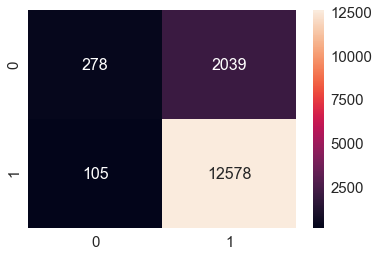

In [23]:
%%time
#Metrics 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import recall_score 

knn = KNeighborsClassifier(n_neighbors=13,algorithm='brute')
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 11 is %d%%' % (acc))
print("'\n****Precision on test set: %0.3f"%(precision_score(y_test, pred))) 
print("'\n****Recall on test set: %0.3f"%(recall_score(y_test, pred))) 
print("'\n****F1-Score on test set: %0.3f"%(f1_score(y_test, pred))) 
print("'\n****Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n") 
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2)) 
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')



# KD_TREE ALGORITHM

In [24]:
%%time
from time import time
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    # fitting the model on crossvalidation train
    knn.fit(X_train, y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))


CV accuracy for k = 1 is 82%

CV accuracy for k = 3 is 84%

CV accuracy for k = 5 is 84%

CV accuracy for k = 7 is 85%

CV accuracy for k = 9 is 85%

CV accuracy for k = 11 is 85%

CV accuracy for k = 13 is 85%

CV accuracy for k = 15 is 85%

CV accuracy for k = 17 is 85%

CV accuracy for k = 19 is 85%

CV accuracy for k = 21 is 85%

CV accuracy for k = 23 is 85%

CV accuracy for k = 25 is 85%

CV accuracy for k = 27 is 85%

CV accuracy for k = 29 is 85%
Wall time: 4h 25min 18s



****Test accuracy for k = 13 is 85%
'
****Precision on test set: 0.861
'
****Recall on test set: 0.992
'
****F1-Score on test set: 0.922
'
****Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Wall time: 24min 45s


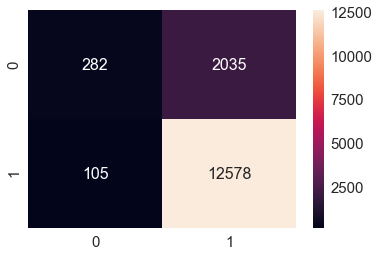

In [25]:
%%time
#Metrics 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import recall_score 

knn = KNeighborsClassifier(n_neighbors=13,algorithm='kd_tree')
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 13 is %d%%' % (acc))
print("'\n****Precision on test set: %0.3f"%(precision_score(y_test, pred))) 
print("'\n****Recall on test set: %0.3f"%(recall_score(y_test, pred))) 
print("'\n****F1-Score on test set: %0.3f"%(f1_score(y_test, pred))) 
print("'\n****Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n") 
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2)) 
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


# TF-IDF

In [30]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.model_selection import train_test_split


#Splitting the data in o train and test data sets
X_train, X_test, y_train, y_test=train_test_split(final_sample['CleanedText'].values,final_sample['Score'].values,test_size=0.3,random_state=0)

# split the train data set into cross validation train and cross validation test
X_train, X_cv, y_train, y_cv = cross_validation.train_test_split(X_train, y_train, test_size=0.3)


tf_idf_vect = TfidfVectorizer(max_features=2500,min_df=50)
X_train = tf_idf_vect.fit_transform(X_train)
print(X_train.shape)
print(type(X_train))

X_cv=tf_idf_vect.transform(X_cv)
print(X_cv.shape)
print(type(X_cv))

X_test = tf_idf_vect.transform(X_test)
print(X_test.shape)
print(type(X_test))



(24500, 1851)
<class 'scipy.sparse.csr.csr_matrix'>
(10500, 1851)
<class 'scipy.sparse.csr.csr_matrix'>
(15000, 1851)
<class 'scipy.sparse.csr.csr_matrix'>


In [31]:
from sklearn import preprocessing

X_train=preprocessing.normalize(X_train)
print(X_train.shape)

X_test=preprocessing.normalize(X_test)
print(X_test.shape)

X_cv=preprocessing.normalize(X_cv)
print(X_cv.shape)

print(type(X_test.shape))

(24500, 1851)
(15000, 1851)
(10500, 1851)
<class 'tuple'>


In [32]:
X_train=pd.DataFrame(X_train.toarray())
print(type(X_train))
print(X_train.shape)


X_cv=pd.DataFrame(X_cv.toarray())
print(type(X_cv))
print(X_cv.shape)

X_test=pd.DataFrame(X_test.toarray())
print(type(X_test))
print(X_test.shape)

<class 'pandas.core.frame.DataFrame'>
(24500, 1851)
<class 'pandas.core.frame.DataFrame'>
(10500, 1851)
<class 'pandas.core.frame.DataFrame'>
(15000, 1851)


# BRUTE FORCE ALGORITHM

In [33]:
%%time
from time import time
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

    # fitting the model on crossvalidation train
    knn.fit(X_train, y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))


CV accuracy for k = 1 is 83%

CV accuracy for k = 3 is 85%

CV accuracy for k = 5 is 85%

CV accuracy for k = 7 is 85%

CV accuracy for k = 9 is 85%

CV accuracy for k = 11 is 85%

CV accuracy for k = 13 is 85%

CV accuracy for k = 15 is 85%

CV accuracy for k = 17 is 85%

CV accuracy for k = 19 is 85%

CV accuracy for k = 21 is 85%

CV accuracy for k = 23 is 85%

CV accuracy for k = 25 is 85%

CV accuracy for k = 27 is 85%

CV accuracy for k = 29 is 85%
Wall time: 14min 48s



****Test accuracy for k = 11 is 85%
'
****Precision on test set: 0.860
'
****Recall on test set: 0.994
'
****F1-Score on test set: 0.922
'
****Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Wall time: 6min 6s


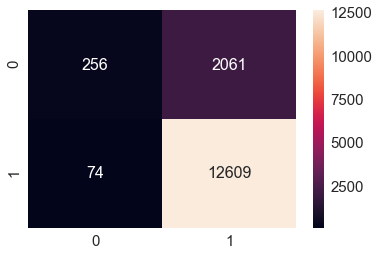

In [34]:
%%time
#Metrics 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import recall_score 

knn = KNeighborsClassifier(n_neighbors=13,algorithm='brute')
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 11 is %d%%' % (acc))
print("'\n****Precision on test set: %0.3f"%(precision_score(y_test, pred))) 
print("'\n****Recall on test set: %0.3f"%(recall_score(y_test, pred))) 
print("'\n****F1-Score on test set: %0.3f"%(f1_score(y_test, pred))) 
print("'\n****Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n") 
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2)) 
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# KD_TREE

In [35]:
%%time
from time import time
for i in range(1,20,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    # fitting the model on crossvalidation train
    knn.fit(X_train, y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))


CV accuracy for k = 1 is 83%

CV accuracy for k = 3 is 85%

CV accuracy for k = 5 is 85%

CV accuracy for k = 7 is 85%

CV accuracy for k = 9 is 85%

CV accuracy for k = 11 is 85%

CV accuracy for k = 13 is 85%

CV accuracy for k = 15 is 85%

CV accuracy for k = 17 is 85%

CV accuracy for k = 19 is 85%
Wall time: 2h 54min 33s



****Test accuracy for k = 13 is 85%
'
****Precision on test set: 0.860
'
****Recall on test set: 0.994
'
****F1-Score on test set: 0.922
'
****Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Wall time: 23min 46s


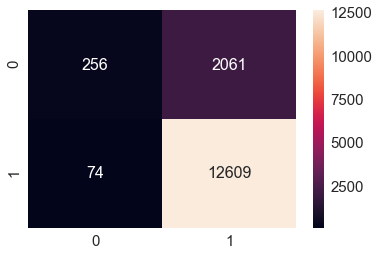

In [36]:
%%time
#Metrics 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import recall_score 

knn = KNeighborsClassifier(n_neighbors=13,algorithm='kd_tree')
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 13 is %d%%' % (acc))
print("'\n****Precision on test set: %0.3f"%(precision_score(y_test, pred))) 
print("'\n****Recall on test set: %0.3f"%(recall_score(y_test, pred))) 
print("'\n****F1-Score on test set: %0.3f"%(f1_score(y_test, pred))) 
print("'\n****Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n") 
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2)) 
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# AVG-W2V

In [37]:
import warnings
warnings.filterwarnings("ignore")
import gensim
i=0
list_of_sent=[]
for sent in final_sample['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


from gensim.models import Word2Vec
from gensim.models import KeyedVectors

w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4) 
#training our own model

In [41]:
%%time
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

50000
50
Wall time: 17.2 s


In [42]:
A=np.array(sent_vectors)
type(A)
#conerting list into array uding numpy

numpy.ndarray

In [43]:
np.isnan(A).any()

False

In [46]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

avg_vec_norm = preprocessing.normalize(A)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(A,final_sample['Score'].values,test_size=0.3,shuffle=False)

# split the train data set into cross validation train and cross validation test
X_train, X_cv, y_train, y_cv = cross_validation.train_test_split(X_train, y_train, test_size=0.3)

print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)


(24500, 50)
(10500, 50)
(15000, 50)


# BRUTE FORCE ALGORITHM

In [47]:
%%time
from time import time
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

    # fitting the model on crossvalidation train
    knn.fit(X_train, y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))


CV accuracy for k = 1 is 82%

CV accuracy for k = 3 is 85%

CV accuracy for k = 5 is 86%

CV accuracy for k = 7 is 86%

CV accuracy for k = 9 is 87%

CV accuracy for k = 11 is 87%

CV accuracy for k = 13 is 87%

CV accuracy for k = 15 is 87%

CV accuracy for k = 17 is 87%

CV accuracy for k = 19 is 87%

CV accuracy for k = 21 is 87%

CV accuracy for k = 23 is 87%

CV accuracy for k = 25 is 87%

CV accuracy for k = 27 is 86%

CV accuracy for k = 29 is 87%
Wall time: 2min 3s



****Test accuracy for k = 13 is 85%
'
****Precision on test set: 0.861
'
****Recall on test set: 0.978
'
****F1-Score on test set: 0.916
'
****Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Wall time: 1min 25s


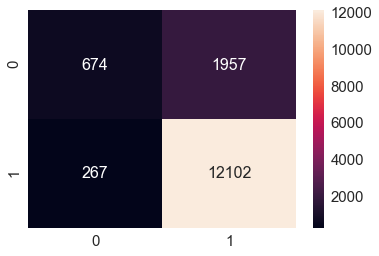

In [48]:
%%time
#Metrics 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import recall_score 

knn = KNeighborsClassifier(n_neighbors=11,algorithm='brute')
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 11 is %d%%' % (acc))
print("'\n****Precision on test set: %0.3f"%(precision_score(y_test, pred))) 
print("'\n****Recall on test set: %0.3f"%(recall_score(y_test, pred))) 
print("'\n****F1-Score on test set: %0.3f"%(f1_score(y_test, pred))) 
print("'\n****Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n") 
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2)) 
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# KD-TREE 

In [51]:
%%time
from time import time
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    # fitting the model on crossvalidation train
    knn.fit(X_train, y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy of the knn classifier for k = %d is %f%%' % (i, acc))


CV accuracy of the knn classifier for k = 1 is 82.676190%

CV accuracy of the knn classifier for k = 3 is 85.866667%

CV accuracy of the knn classifier for k = 5 is 86.638095%

CV accuracy of the knn classifier for k = 7 is 86.866667%

CV accuracy of the knn classifier for k = 9 is 87.095238%

CV accuracy of the knn classifier for k = 11 is 87.123810%

CV accuracy of the knn classifier for k = 13 is 87.095238%

CV accuracy of the knn classifier for k = 15 is 87.000000%

CV accuracy of the knn classifier for k = 17 is 87.190476%

CV accuracy of the knn classifier for k = 19 is 87.219048%

CV accuracy of the knn classifier for k = 21 is 87.333333%

CV accuracy of the knn classifier for k = 23 is 87.190476%

CV accuracy of the knn classifier for k = 25 is 87.066667%

CV accuracy of the knn classifier for k = 27 is 86.971429%

CV accuracy of the knn classifier for k = 29 is 87.009524%
Wall time: 8h 54min 34s



****Test accuracy of the knn classifier for k = 21 is 84.993333%
'
****Precision on test set: 0.855
'
****Recall on test set: 0.984
'
****F1-Score on test set: 0.915
'
****Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Wall time: 1min 21s


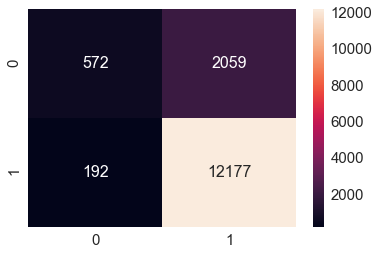

In [52]:
%%time
#Metrics 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import recall_score 

knn = KNeighborsClassifier(n_neighbors=21,algorithm='kd_tree')
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy of the knn classifier for k = 21 is %f%%' % (acc))
print("'\n****Precision on test set: %0.3f"%(precision_score(y_test, pred))) 
print("'\n****Recall on test set: %0.3f"%(recall_score(y_test, pred))) 
print("'\n****F1-Score on test set: %0.3f"%(f1_score(y_test, pred))) 
print("'\n****Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n") 
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2)) 
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# TF-IDF_W2V

In [57]:
tf_idf_vect = TfidfVectorizer(ngram_range=(0,1))
final_tf_idf = tf_idf_vect.fit_transform(final_sample['CleanedText'].values)
final_tf_idf.get_shape()

(50000, 27445)

In [56]:
# TF-IDF weighted Word2Vec
tf_idf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            #import pdb; pdb.set_trace()
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tf_idf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [58]:
tfidf_sent_vectors[0]

array([-0.21869988, -0.59323639, -0.57038278,  0.04705684, -0.09912616,
       -0.10050436, -0.56248766, -0.65312725,  0.76150977,  0.03838799,
        0.30220333, -0.33952546,  0.16900865,  0.13370937, -0.15767699,
        0.21830697,  0.00979195, -0.14994382, -0.44858625, -0.09563225,
       -0.15701913, -0.12403605, -0.46520647, -0.28856974, -0.29099107,
       -0.42829158, -0.02113629, -0.54719338,  0.01679843, -0.47504409,
        0.66011233, -0.59496357,  0.27255388, -0.22784349,  0.02586302,
        0.26194787,  0.46978518,  0.07000439, -0.21839312,  0.55986911,
        0.42964042,  0.02972367, -0.06419189,  0.88738633,  0.17247727,
        0.22681035,  0.37902101,  0.00563155, -0.45955544, -0.03128806])

In [59]:
A=np.array(tfidf_sent_vectors)
A.shape
#Using numpy.array to convert the obtained list into array

(50000, 50)

In [60]:
from sklearn.preprocessing import Imputer

Tf_idf_w2v = Imputer().fit_transform(A)
#Imputer function to fill the missing data

In [64]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

avg_vec_norm = preprocessing.normalize(Tf_idf_w2v)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(Tf_idf_w2v,final_sample['Score'].values,test_size=0.3,shuffle=False)

# split the train data set into cross validation train and cross validation test
X_train, X_cv, y_train, y_cv = cross_validation.train_test_split(X_train, y_train, test_size=0.3)

print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(24500, 50)
(10500, 50)
(15000, 50)


# BRUTE FORCE 

In [65]:
%%time
from time import time
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

    # fitting the model on crossvalidation train
    knn.fit(X_train, y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy of the knn classifier for k = %d is %f%%' % (i, acc))


CV accuracy of the knn classifier for k = 1 is 79.457143%

CV accuracy of the knn classifier for k = 3 is 83.295238%

CV accuracy of the knn classifier for k = 5 is 84.847619%

CV accuracy of the knn classifier for k = 7 is 85.609524%

CV accuracy of the knn classifier for k = 9 is 85.714286%

CV accuracy of the knn classifier for k = 11 is 85.809524%

CV accuracy of the knn classifier for k = 13 is 85.838095%

CV accuracy of the knn classifier for k = 15 is 85.809524%

CV accuracy of the knn classifier for k = 17 is 85.838095%

CV accuracy of the knn classifier for k = 19 is 85.952381%

CV accuracy of the knn classifier for k = 21 is 85.933333%

CV accuracy of the knn classifier for k = 23 is 85.923810%

CV accuracy of the knn classifier for k = 25 is 85.942857%

CV accuracy of the knn classifier for k = 27 is 85.847619%

CV accuracy of the knn classifier for k = 29 is 85.800000%
Wall time: 1min 46s



****Test accuracy of the knn classifier for k = 19 is 83.213333%
'
****Precision on test set: 0.837
'
****Recall on test set: 0.988
'
****F1-Score on test set: 0.907
'
****Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Wall time: 1min 12s


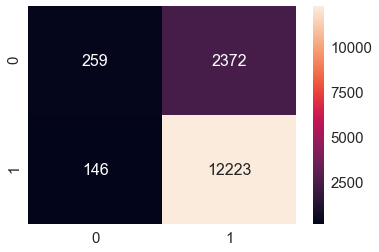

In [66]:
%%time
#Metrics 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import recall_score 

knn = KNeighborsClassifier(n_neighbors=19,algorithm='brute')
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy of the knn classifier for k = 19 is %f%%' % (acc))
print("'\n****Precision on test set: %0.3f"%(precision_score(y_test, pred))) 
print("'\n****Recall on test set: %0.3f"%(recall_score(y_test, pred))) 
print("'\n****F1-Score on test set: %0.3f"%(f1_score(y_test, pred))) 
print("'\n****Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n") 
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2)) 
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# KD-TREE

In [67]:
%%time
from time import time
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    # fitting the model on crossvalidation train
    knn.fit(X_train, y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy of the knn classifier for k = %d is %f%%' % (i, acc))


CV accuracy of the knn classifier for k = 1 is 79.457143%

CV accuracy of the knn classifier for k = 3 is 83.295238%

CV accuracy of the knn classifier for k = 5 is 84.847619%

CV accuracy of the knn classifier for k = 7 is 85.609524%

CV accuracy of the knn classifier for k = 9 is 85.714286%

CV accuracy of the knn classifier for k = 11 is 85.809524%

CV accuracy of the knn classifier for k = 13 is 85.838095%

CV accuracy of the knn classifier for k = 15 is 85.809524%

CV accuracy of the knn classifier for k = 17 is 85.838095%

CV accuracy of the knn classifier for k = 19 is 85.952381%

CV accuracy of the knn classifier for k = 21 is 85.933333%

CV accuracy of the knn classifier for k = 23 is 85.923810%

CV accuracy of the knn classifier for k = 25 is 85.942857%

CV accuracy of the knn classifier for k = 27 is 85.847619%

CV accuracy of the knn classifier for k = 29 is 85.800000%
Wall time: 10min 49s



****Test accuracy of the knn classifier for k = 19 is 83.213333%
'
****Precision on test set: 0.837
'
****Recall on test set: 0.988
'
****F1-Score on test set: 0.907
'
****Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Wall time: 1min 6s


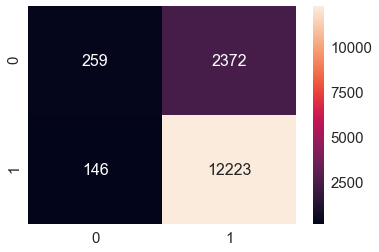

In [68]:
%%time
#Metrics 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import recall_score 

knn = KNeighborsClassifier(n_neighbors=19,algorithm='kd_tree')
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy of the knn classifier for k = 19 is %f%%' % (acc))
print("'\n****Precision on test set: %0.3f"%(precision_score(y_test, pred))) 
print("'\n****Recall on test set: %0.3f"%(recall_score(y_test, pred))) 
print("'\n****F1-Score on test set: %0.3f"%(f1_score(y_test, pred))) 
print("'\n****Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n") 
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2)) 
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# MODEL PERFORMANCE

# CONCLUSION:

1)K-NN with 50k points took lot of time to train the dataset

2)Best accuracy for K-NN is achieved with AVG-W2V i.e 87.33%

3)KD-TREE and BRUTE force algorithms for feautirazations giving similiar results

4)Overall for imbalanced dataset k-nn might not be the best option.
